## Bike sharing systems

#### **Overview**

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

#### **Data Fields**

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals (Dependent Variable)



## 1. Business Understanding
Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city.
Can we combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C



## 2. Data Understanding

 

In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

#### **2.1 Gather data**

In [2]:
DataTrain = pd.read_csv("train.csv")
DataTest = pd.read_csv("test.csv")

Dataset = DataTrain.append(DataTest,sort ="False")
Dataset.reset_index(inplace=True)
Dataset.drop('index',inplace=True,axis=1)

#### **Variables Data Type**

In [3]:
Dataset.dtypes

atemp         float64
casual        float64
count         float64
datetime       object
holiday         int64
humidity        int64
registered    float64
season          int64
temp          float64
weather         int64
windspeed     float64
workingday      int64
dtype: object

##  3. Data Preparation & cleaning

Preliminary exploreation of dataset revealed that the data is not clean and there are fields that may not be relevant for analysis.

As we see from the above results, the columns "season","holiday","workingday" and "weather" should be of "categorical" data type.But the current data type is "int" for those columns. Let us transform the dataset in the following ways so that we can get started up with our EDA


#### **Creating New Columns From "Datetime" Column**

In [4]:
Dataset["date"] = Dataset.datetime.apply(lambda x : x.split()[0])
Dataset["hour"] = Dataset.datetime.apply(lambda x : x.split()[1].split(":")[0])
Dataset["year"] = Dataset.datetime.apply(lambda x : x.split()[0].split("-")[0])
Dataset["weekday"] = Dataset.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
Dataset["month"] = Dataset.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)
#Dataset["season"] = Dataset.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
#Dataset["weather"] = Dataset.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
#                                         2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
#                                         3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
#                                         4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })
dataWindspeedOriginal = Dataset["windspeed"]

**Exploratory data analysis using Pandas_profiling**

In [5]:
import pandas_profiling
profile = Dataset.profile_report(title='Bike Sharing Profiling Report')
profile.to_file(output_file="Bike_sharing_profiling.html")


**Outliers Analysis**

 - Spring season has got relatively lower count.The dip in median value
   in boxplot gives evidence for it.
 - The boxplot with "Hour Of The Day" is quiet interesting.The median value are relatively higher at 7AM - 8AM and 5PM - 6PM. It can be attributed to regular school and office users at that time. 
 - Most of the outlier points are mainly contributed from "Working Day" than "Non Working Day". It is quiet visible from from figure 4.

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

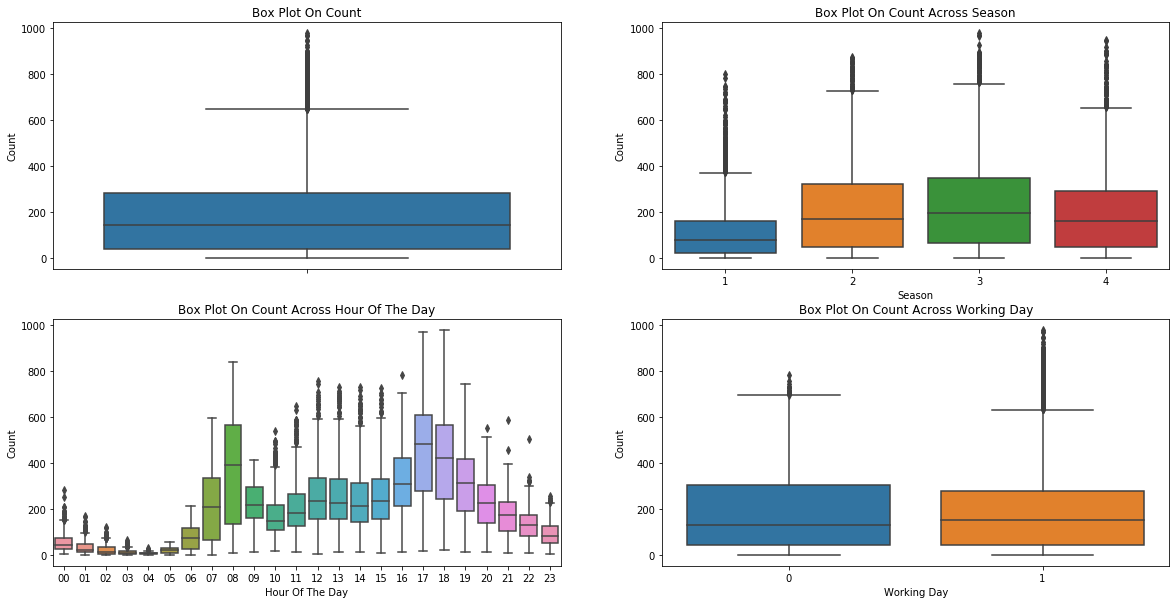

In [6]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 10)
sn.boxplot(data=Dataset,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=Dataset,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=Dataset,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=Dataset,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

#### **Remove Outliers**

In [7]:
dailyDataWithoutOutliers = Dataset[np.abs(Dataset["count"]-Dataset["count"].mean())<=(3*Dataset["count"].std())] 

In [8]:
print ("Shape Of The Before Ouliers: ",Dataset.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (17379, 17)
Shape Of The After Ouliers:  (10739, 17)


In [9]:
data = dailyDataWithoutOutliers
data.head(2)

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,hour,year,weekday,month
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0,2011-01-01,00,2011,5,1
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0,2011-01-01,01,2011,5,1


In [10]:
### Missing Value of Windspeed 

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Windspeed Values'),
 Text(0.5, 1.0, 'Count Of Windspeed Values Before Imputing'),
 None]

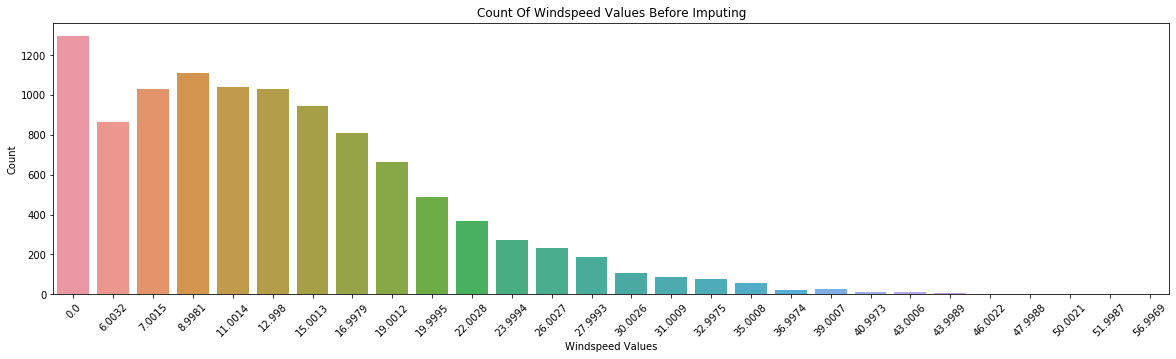

In [11]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
windspeed = pd.DataFrame(data.windspeed.value_counts()).reset_index()
plt.xticks(rotation=45) 
sn.barplot(data=windspeed,x="index",y="windspeed",ax=ax)
ax.set(xlabel='Windspeed Values', ylabel='Count',title="Count Of Windspeed Values Before Imputing",label='big')

In [12]:
from sklearn.ensemble import RandomForestClassifier

windColumns = ["season","weather","humidity","month","temp","year","atemp"]
dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

rfModel_wind = RandomForestClassifier()
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])
wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])

dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data["windspeed"] = data["windspeed"].astype("float")
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

E:\Users\tsu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


**Distribution after**

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Windspeed Values'),
 Text(0.5, 1.0, 'Count Of Windspeed Values After Imputing'),
 None]

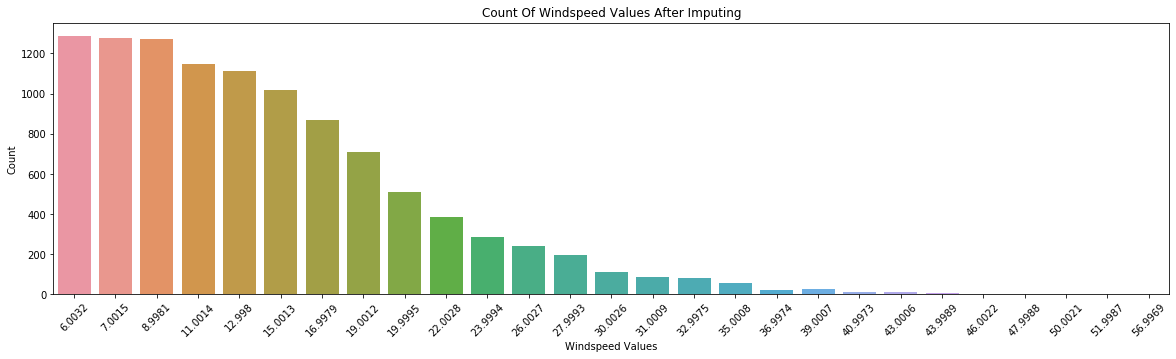

In [13]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
windspeed = pd.DataFrame(data.windspeed.value_counts()).reset_index()
plt.xticks(rotation=45) 
sn.barplot(data=windspeed,x="index",y="windspeed",ax=ax)
ax.set(xlabel='Windspeed Values', ylabel='Count',title="Count Of Windspeed Values After Imputing",label='big')

In [14]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
#numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
#dropFeatures = ['casual',"count","datetime","date","registered","temp","windspeed","year"]

for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [15]:
features_cyc = ['season', 'hour', 'month', 'weekday']

for feature in features_cyc:
    data[feature] = data[feature].astype(np.int8)
    data[feature+'_sin'] = np.sin((2*np.pi*data[feature])/max(data[feature]))
    data[feature+'_cos'] = np.cos((2*np.pi*data[feature])/max(data[feature]))
data = data.drop(features_cyc, axis=1)
data.dtypes

atemp           float64
casual          float64
count           float64
datetime         object
holiday        category
humidity          int64
registered      float64
temp            float64
weather        category
windspeed       float64
workingday     category
date             object
year           category
season_sin      float64
season_cos      float64
hour_sin        float64
hour_cos        float64
month_sin       float64
month_cos       float64
weekday_sin     float64
weekday_cos     float64
dtype: object

## Exploratory data Analysis

In [16]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
# yLablesRegistered = dataTrain["registered"]
# yLablesCasual = dataTrain["casual"]

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split( dataTrain, yLabels, test_size=0.3, random_state=42)
dateTimeColValidate = X_validate["datetime"]

In [18]:
##Partial solution catego variab are deleted
dropFeatures = ['casual',"count","datetime","date","registered","temp","windspeed","year","holiday","weather","workingday"]

dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)
X_train = X_train.drop(dropFeatures,axis=1)
X_validate = X_validate.drop(dropFeatures,axis=1)

In [20]:
import pandas_profiling
profile = X_train.profile_report(title='Training data Report')
profile.to_file(output_file="training dataset-report.html")


In [21]:
###Scaling data
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_validate)
# y_train = np.log1p(y_train)

## 4. Modeling & Evaluation##

**RMSLE Scorer**

In [22]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [23]:
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

## **Linear Regression Model** ##

In [25]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
lModel.fit(X = X_train,y = np.log1p(y_train))

# Make predictions
preds = lModel.predict(X= X_validate)
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds),False))


RMSLE Value For Linear Regression In Validation:  0.8956902034383775


**Visualizing Distribution Of Train And Test**

[Text(0.5, 1.0, 'Test Set Distribution')]

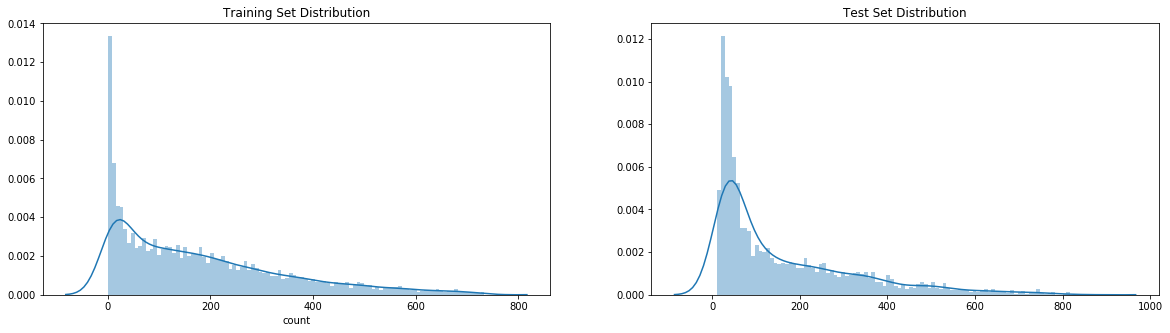

In [26]:
predsTest = lModel.predict(X=X_validate)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(20,5)
sn.distplot(yLabels,ax=ax1,bins=100)
sn.distplot(np.exp(predsTest),ax=ax2,bins=100)
ax1.set(title="Training Set Distribution")
ax2.set(title="Test Set Distribution")

## **Regularization Model -  Ridge** ##

{'alpha': 30, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.8953331658574737


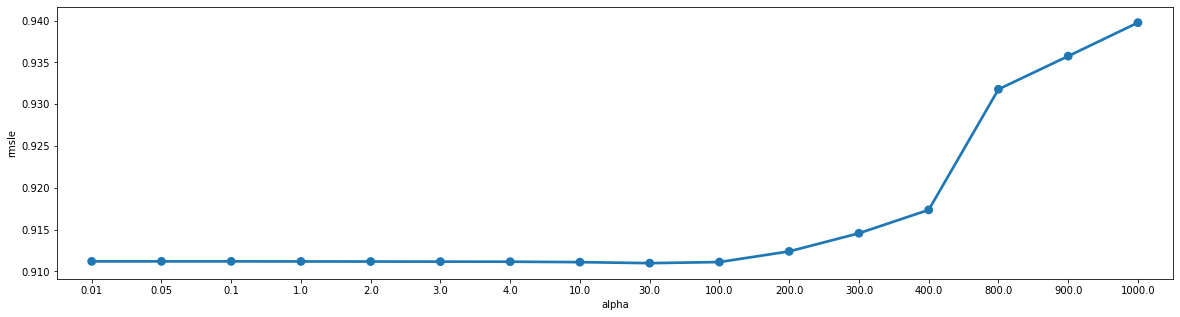

In [27]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01,0.05,0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
grid_ridge_m.fit(X = X_train,y = np.log1p(y_train))
preds = grid_ridge_m.predict(X= X_validate)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(20,5)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)


## **Regularization Model - Lasso** ##

{'alpha': 0.001, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.8956427876621349


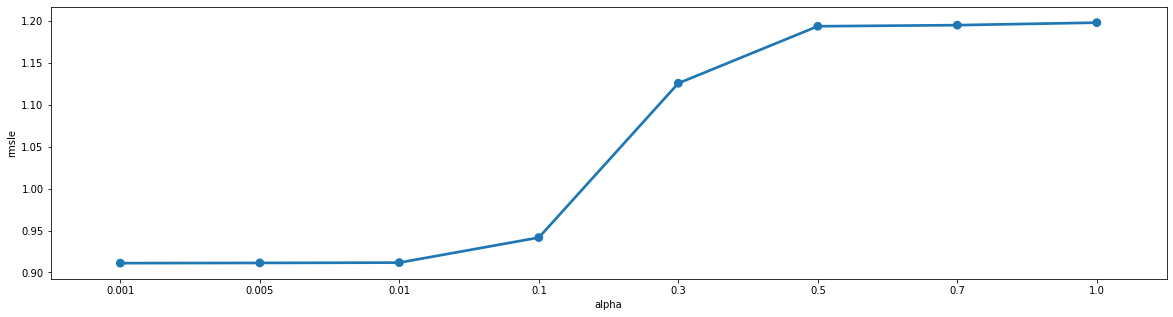

In [29]:
from sklearn.linear_model import Lasso
lasso_m_ = Lasso()

alpha  = [0.001,0.005,0.01,0.3,0.1,0.3,0.5,0.7,1]
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit(X = X_train,y = np.log1p(y_train))
preds = grid_lasso_m.predict(X= X_validate)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(20,5)
df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## **Ensemble Models - Random Forest** ##

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rfModel = RandomForestRegressor(n_estimators=100) ### Test 0.44
rfModel.fit(X = X_train,y = np.log1p(y_train))
preds = rfModel.predict(X= X_validate)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds),False))

RMSLE Value For Random Forest:  0.5161786295185675


**Feature Importance By Random Forest**

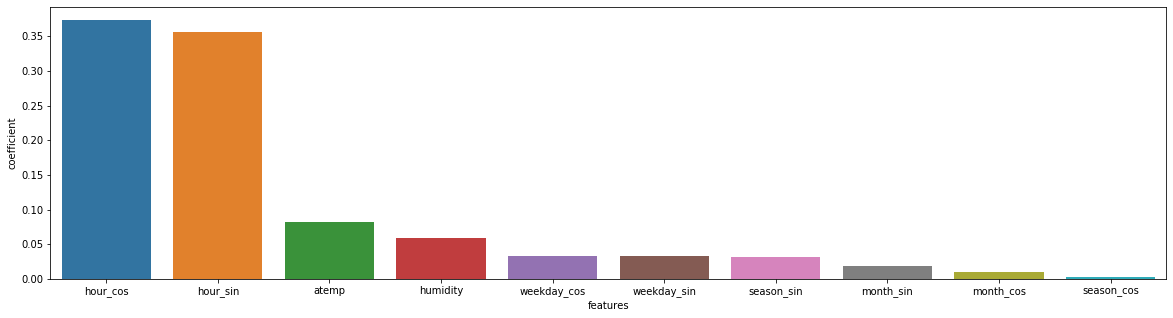

In [32]:
features = pd.DataFrame()
features['features'] = X_train.columns
features['coefficient'] = rfModel.feature_importances_
features.sort_values(by=['coefficient'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=features,x="features",y="coefficient",ax=ax)


## **Ensemble Model - Gradient Boost** ##

In [33]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01) ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(X = X_train,y = np.log1p(y_train))
preds = gbm.predict(X= X_validate)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds),False))

RMSLE Value For Gradient Boost:  0.4991164809598335


**Lets compare the distribution of train and test results. More or less the distribution of train and test looks identical. It  confirms visually that our model has not predicted really bad and not suffering from major overfitting problem.**

[Text(0.5, 1.0, 'Test Set Distribution')]

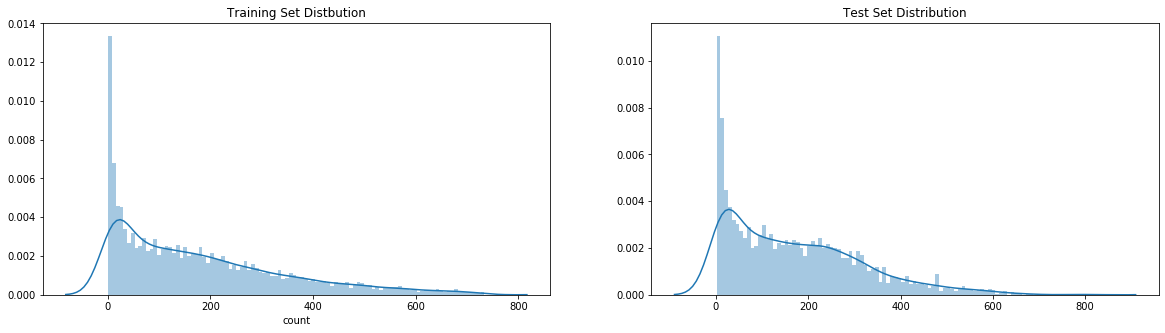

In [34]:
predsTest = gbm.predict(X=X_validate)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(20,5)
sn.distplot(yLabels,ax=ax1,bins=100)
sn.distplot(np.exp(predsTest),ax=ax2,bins=100)
ax1.set(title="Training Set Distbution")
ax2.set(title="Test Set Distribution")